In [1]:
# uncomment the last two cell to clone the data and enable the GPU
#! git clone https://github.com/ParsProgrammer/ERS.git

In [2]:
#cd ERS

# **Packages**

In [3]:
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import gzip
import gc
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
import datetime 
import os
import matplotlib.pyplot as plt


In [7]:
%pip install gensim==4.2
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize


In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else :
  print("No GPU available")

2022-12-17 17:19:43.118036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:19:43.194731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:19:43.194962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:19:43.196621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs


In [11]:
%pip install tensorboard
%pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# **Data Extraction**

In [12]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [13]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


In [14]:
df.sample(10)

,userID,itemID,reviewText,rating
49909,A2SE5EJ7B6Z8NP,B001EO5OKC,I put gogi berries in my smoothies every day. ...,5.0
130474,AVFA1JB08RG8G,B0085000BG,"This instant coffee offering, Pure Indulgence,...",4.0
70741,A2MUGFV2TDQ47K,B002EDIJH2,Original 1 STAR Rating Chocolate Chip Cookies:...,1.0
84783,AJFMYOLRWDJ46,B003P79DFI,Jif is the only peanut butter for me. Nothing ...,5.0
22403,AXBC52UXVOIO0,B000GZUBAS,I love mum-mums! My kids go crazy for them. My...,5.0
149854,A336FE20YZZL3A,B00H727T58,We love this stuff at our house! We are family...,5.0
13870,A311YKH6RB7AWY,B000ETC36Q,good noodles for a good price. After many tos...,3.0
112125,A12PNSO4FPOHH,B0054TWPNC,I actually eat this for breakfast some times w...,5.0
19297,A2AAYN4ZVC5R0,B000FFRU3U,"I am currently deployed and seeking healthy, f...",5.0
48603,A3VTSPF7JQ80UQ,B001E5E3NK,Goes very far. About one per 20oz seems to do ...,5.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [15]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


**Item Data**

determining all unique items with their reviews and ratings

In [16]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


In [17]:
# dataset minimization
sample_userID = list( user_df[user_df['reviewText'].apply(lambda x : len(x)> 80 )].sample(50)['userID'])
new_df = df[ df['userID'].isin(sample_userID)]
item_ddf = new_df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
sample_itemID = list( item_ddf[ item_ddf['reviewText'].apply(lambda x : len(x)>4)]['itemID'] )
df = new_df[new_df['itemID'].isin(sample_itemID)].reset_index(drop= True)
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()


/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [18]:
print("review num : ", df.shape[0] ,"user num : " ,user_df.shape[0],"item num : ",item_df.shape[0] )

review num :  1878 user num :  50 item num :  195


##   Ratings

count    1878.000000
mean        3.943024
std         1.029378
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

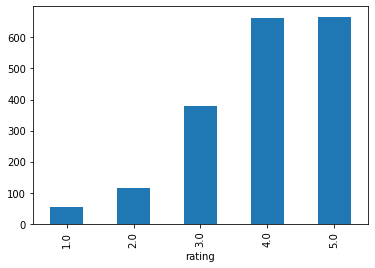

In [19]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

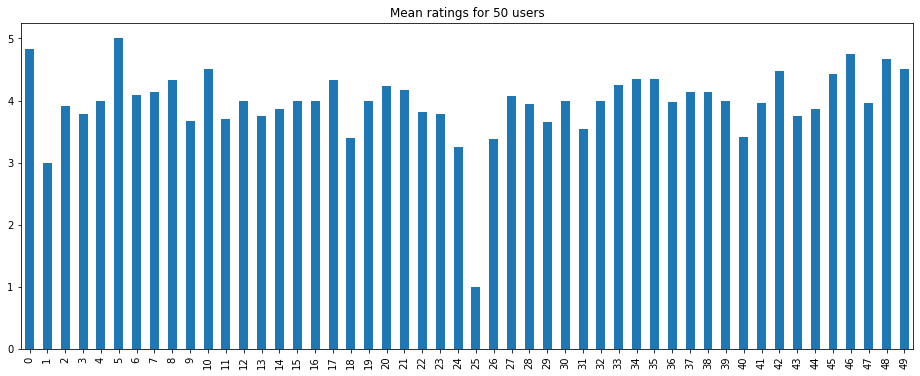

In [20]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

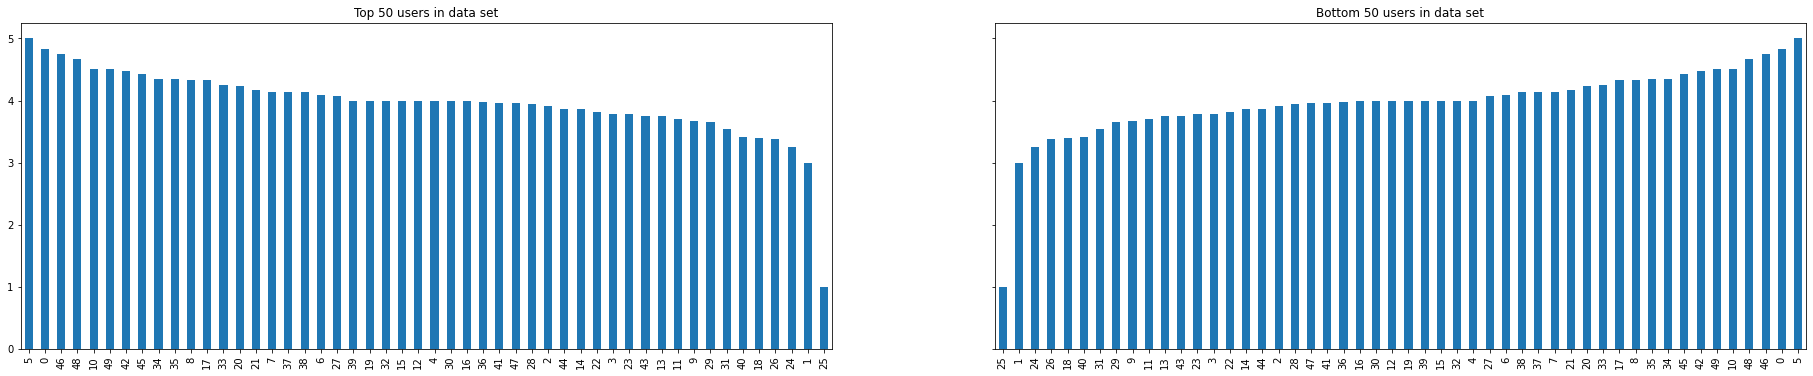

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

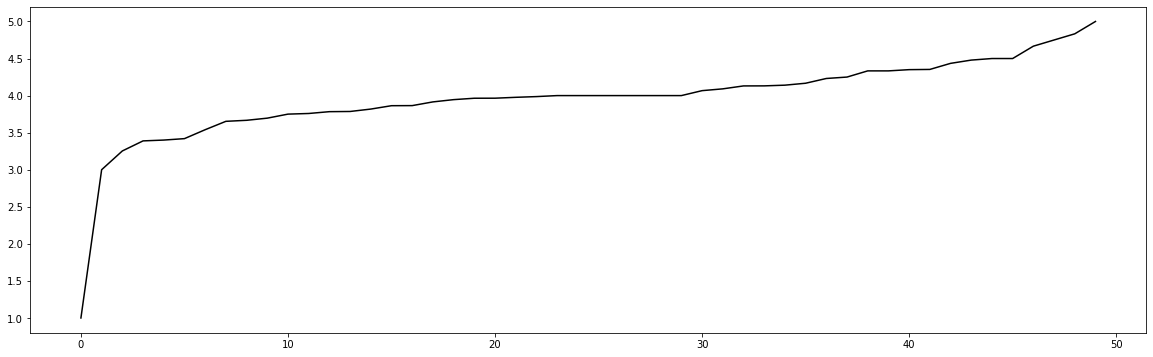

In [22]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


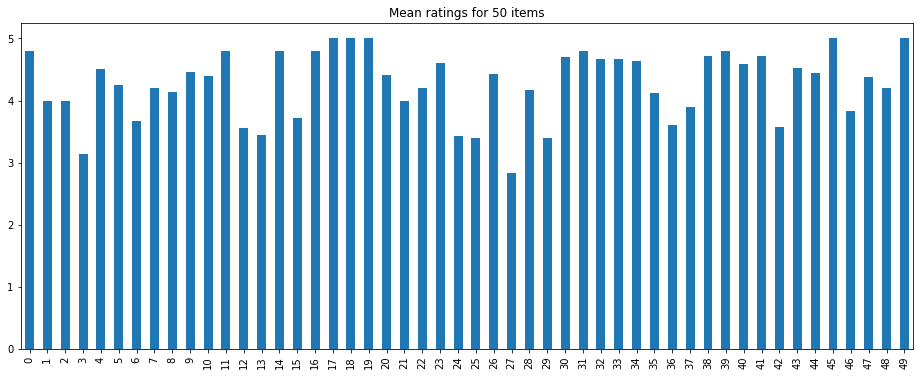

In [23]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

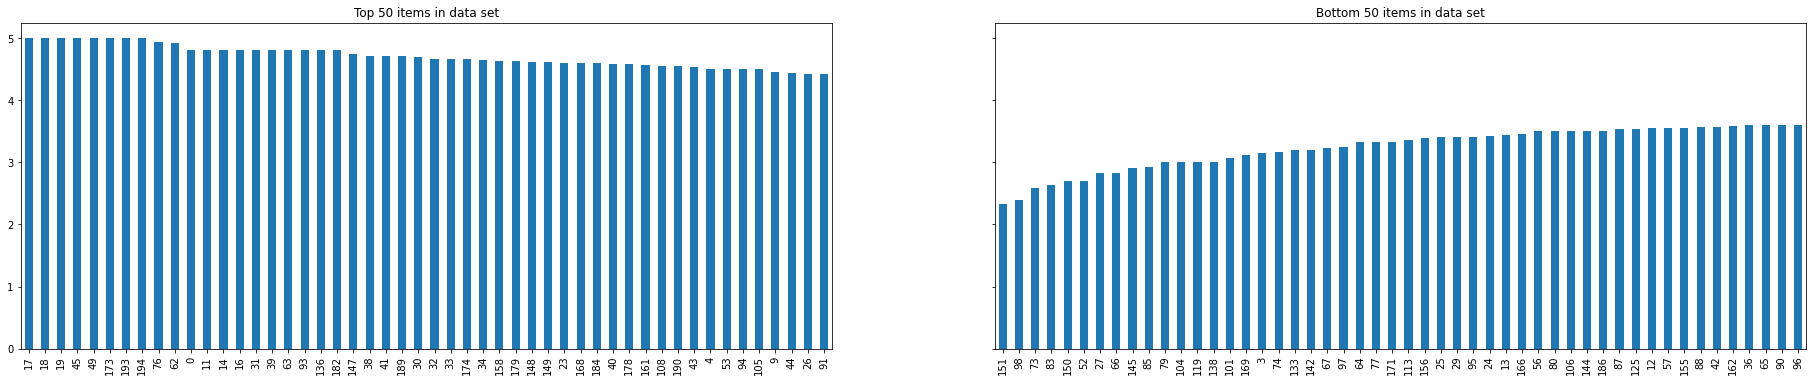

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [25]:
df['reviewText'].describe()

count                                                  1878
unique                                                 1878
top       Many reviewers have already commented on the f...
freq                                                      1
Name: reviewText, dtype: object

count    1878.000000
mean      733.698083
std       508.239662
min        78.000000
25%       425.250000
50%       602.000000
75%       865.750000
max      8136.000000
Name: reviewText, dtype: float64

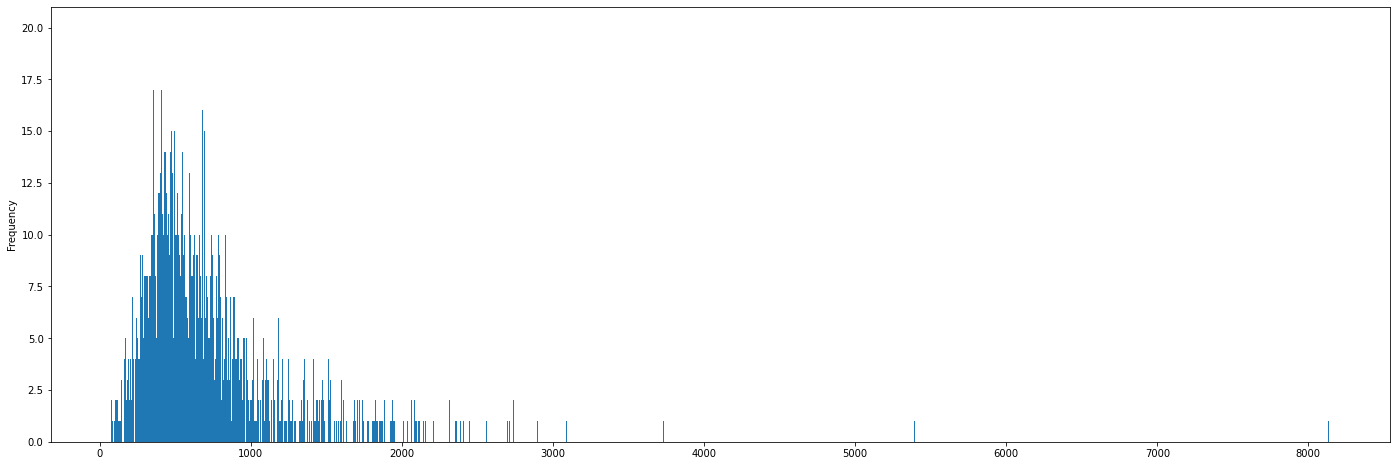

In [26]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [27]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 37.56
mean of words per review: 733.6980830670926
mean of words per user: 27557.7


In [28]:
a=item_df['reviewText'].apply(len)
a[a>40]

Series([], Name: reviewText, dtype: int64)

count    195.000000
mean       9.630769
std        4.447526
min        5.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       30.000000
Name: reviewText, dtype: float64

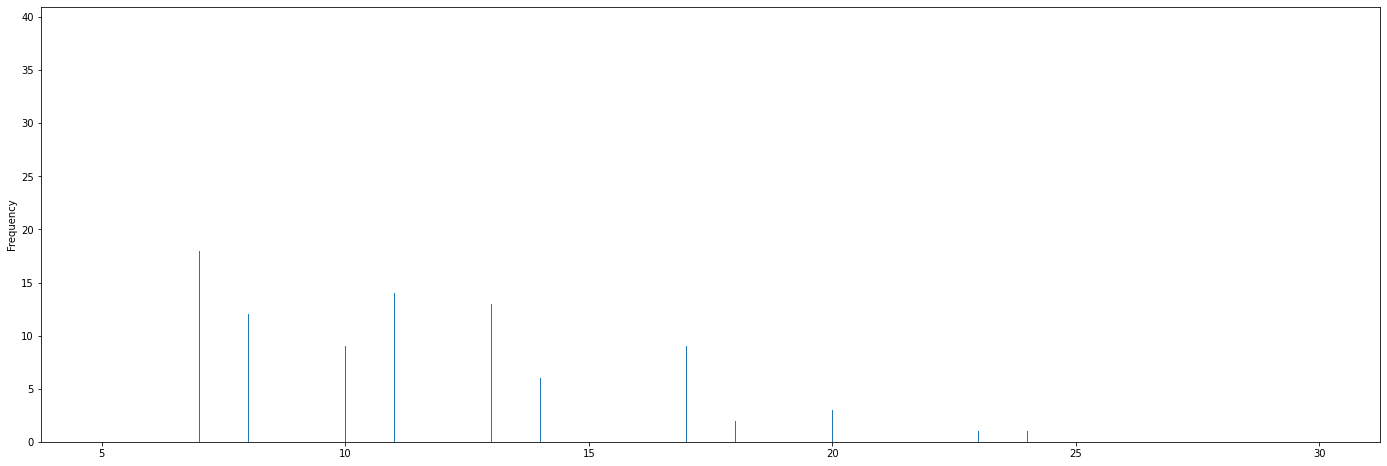

In [29]:
rv_le=item_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

count     50.000000
mean      37.560000
std       29.842553
min        1.000000
25%       12.750000
50%       31.000000
75%       61.750000
max      114.000000
Name: reviewText, dtype: float64

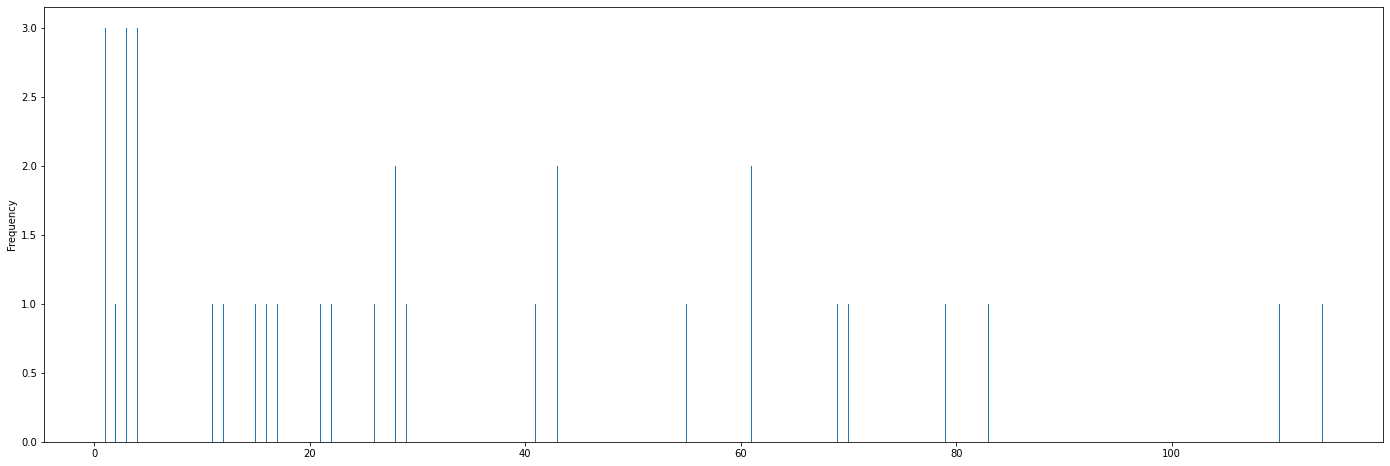

In [30]:
rv_le=user_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

In [31]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 9.63076923076923
mean of words per review: 733.6980830670926
mean of words per item: 7066.076923076923


# **Data Splitting**

In [32]:
current_fold=10
kfold = KFold(10)
random_iterator=kfold.split(df)
for i in range(current_fold):
  train_index, test_index = next(random_iterator, None)
  print(train_index,len(train_index))
  train_df, test_df =df.iloc[train_index], df.iloc[test_index]
train_df

[ 188  189  190 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1690
[   0    1    2 ... 1875 1876 1877] 1691
[   0    1    2 ... 1688 1689 1690] 1691


,userID,itemID,reviewText,rating
0,A36WGHR8TO5DKT,B00099XNG0,Many reviewers have already commented on the f...,5.0
1,AKMEY1BSHSDG7,B00099XNG0,Chex Mix Sour Cream & Onion flavor is a good s...,4.0
2,A1X1CEGHTHMBL1,B00099XNG0,"Wow, what a mixture of great tasting things. ...",5.0
3,A1ZH9LWMX5UCFJ,B00099XNG0,I have always been a fan of sweet and salty sn...,5.0
4,A2MNB77YGJ3CN0,B00099XNG0,Excellent snack for those of us who prefer our...,5.0
...,...,...,...,...
1686,A2V92F5R7MLCVI,B00DF05TC6,I thought the combination of caramel and chedd...,1.0
1687,A2OCDK0BOW6UCY,B00DGPCC3O,"This is a nice blend consisting of raisins, pe...",4.0
1688,A34BZM6S9L7QI4,B00DGPCC3O,"This isn't outstanding, and by that I mean it ...",4.0
1689,A25C2M3QF9G7OQ,B00DGPCC3O,"This is a very tasty assemblage of nuts, raisi...",4.0


# **Embedding Matrix**

In [33]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=1
max_vocab_size=10000
sequence_length=64
document_length=20

In [34]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text= tf.strings.reduce_join( tf.strings.split(text)[:,:sequence_length-2],axis=-1,separator=' ')
  return  text.numpy()

In [35]:
with tf.device('/CPU:0'):
    user_corpus =list(map(tf_lower_and_split_punct,user_df['reviewText'])) 
    item_corpus = list( map(tf_lower_and_split_punct,item_df['reviewText']) )

In [36]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for i,doc in enumerate(user_corpus):    # iterate through each sentence in the reviews
            for rv in doc:
                for sen in sent_tokenize(rv.decode("utf-8")):
                    temp = []
                    # tokenize the sentence into words          
                    for j in word_tokenize(sen):
                        temp.append(j.lower())
                    text_corpus.append(temp)
                    del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 5,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [37]:
# loading the embedding lookup matrix shape=( 30k ,300 ) approximately
embedding_matrix = load_word2vec_model() 
print( "embedding matrix shape : (",len(embedding_matrix.index_to_key)," ,",embedding_matrix.vector_size,")")

embedding matrix shape : ( 6187  , 300 )


In [38]:
embedding_matrix.index_to_key

['.',
 'the',
 ',',
 'a',
 'and',
 'i',
 'of',
 'to',
 'is',
 'it',
 'this',
 'in',
 'that',
 'but',
 'with',
 'for',
 'are',
 'was',
 'not',
 'like',
 'my',
 'flavor',
 'as',
 'have',
 'good',
 'these',
 'taste',
 'on',
 'they',
 'tea',
 'you',
 'so',
 'or',
 'very',
 'its',
 'be',
 'just',
 'has',
 'one',
 'really',
 'more',
 'than',
 'me',
 'water',
 'all',
 'when',
 'can',
 'some',
 'them',
 'at',
 'little',
 'if',
 'nice',
 'too',
 'from',
 'coffee',
 'pasta',
 'much',
 'we',
 'had',
 'great',
 '!',
 'an',
 'there',
 'sweet',
 'bit',
 'love',
 'out',
 'up',
 'tried',
 'ive',
 'would',
 'easy',
 'which',
 'make',
 'drink',
 'no',
 'well',
 'other',
 'rice',
 'side',
 'chocolate',
 'im',
 'were',
 'do',
 'use',
 'dont',
 'sauce',
 'texture',
 'because',
 'sugar',
 'about',
 'also',
 'better',
 'what',
 'cup',
 'product',
 'tastes',
 'first',
 'get',
 'been',
 'makes',
 'quite',
 'only',
 'used',
 'didnt',
 'cookies',
 'try',
 'tasty',
 'cheese',
 'bag',
 'even',
 'any',
 'made',
 'p

In [39]:
# vocab_size is equal to full_embedding_matrix shape[0]
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(6191, 300)

In [40]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

In [78]:
# hyperparameter

batch_size = 16 # for seq2seq model
batch_size_test = 8 # for seq2seq model
num_batches=int(train_df.shape[0]/batch_size)
num_batches_test=int(test_df.shape[0]/batch_size_test)
print("number of batches in train data",num_batches)
print("number of batches in test data",num_batches_test)

number of batches in train data 105
number of batches in test data 23


## **Preprocessing**

In [79]:
def tf_lower_and_split_punct_enc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


def tf_lower_and_split_punct_decin(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text], separator=' ') 
  return text


def tf_lower_and_split_punct_decout(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join([ text, '[END]'], separator=' ')
  return text



## Vectorization layer

- The conversion of tokens to ids

In [80]:
enc_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_enc,
                                                     output_sequence_length = sequence_length,  )
dec_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decin,
                                                     output_sequence_length = sequence_length,  )

dec_output_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decout,
                                                     output_sequence_length = sequence_length,  )

In [81]:
enc_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_output_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

In [82]:
print(enc_input_processor.get_vocabulary().index('come'))
print(enc_input_processor.get_vocabulary()[3351])

254
purple


In [83]:
# included sos, eos, unk and space 
print("input_text_processor vocab size :" ,len(enc_input_processor.get_vocabulary()))
# Here are the first 16 words from the vocabulary:
print(enc_input_processor.get_vocabulary()[:16])
print(df['reviewText'][0])
print(dec_output_processor(  df['reviewText'][0]))

input_text_processor vocab size : 6191
['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'a', 'and', 'i', 'of', 'to', 'is', 'it', 'this', 'in']
Many reviewers have already commented on the fact that this mix is tasty.  I find it difficult to describe, because it is definitely chocolatey, and sweet, but yet it's not quite like eating candy or cookies etc.  It will handle multiple types of snacking cravings whether you want chocolate, candy, sweet in general, crunchy, crispy, or sweet-salty etc.One thing that surprised me was that all of the pieces in the mix, except the candy drops, are basically sized to match the Chex squares, so they are smaller than I had anticipated.  This is a big plus for me, as I find most "bite-sized" products to be more like "3-bite-sized", and this mix is actually really bite-sized.  This makes it easy to eat and it also is very charming.  I think it would be a good option for children, to whom you could give a small amount in their lunch/bento box or as a s

# **TF-IDF Matrix**

In [84]:
with tf.device('/CPU:0'):

  tfidf_calculator = tf.keras.layers.TextVectorization(
    max_tokens  = max_vocab_size,
    output_mode ='tf-idf',
    pad_to_max_tokens = True  
    )
  tfidf_calculator.adapt(enc_input_processor.get_vocabulary()[:] )
  print("the length of tf-idf vocab",len(tfidf_calculator.get_vocabulary()))
  print( list(set(enc_input_processor.get_vocabulary())-set(tfidf_calculator.get_vocabulary()))[:9])
  print( list(set(embedding_matrix.index_to_key)-set(tfidf_calculator.get_vocabulary()))[:9])


the length of tf-idf vocab 6185
['', '!', '[END]', ',', '.', '[START]', '?']
[',', '.', '!', '?']


In [85]:
# with tf.device('/CPU:0'):

#     user_tfidf = list( map(tfidf_calculator, user_corpus))
#     item_tfidf = list( map(tfidf_calculator, item_corpus))


# **Forming Dataset**

In [86]:
# convert string id to int id
user_to_row = {}
item_to_column = {}

for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

In [87]:
train_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(dec_input_processor(train_df['reviewText']),dtype=tf.int32),
       tf.cast(dec_output_processor(train_df['reviewText']),dtype=tf.int32)       
    )
).shuffle(131072).batch(batch_size,drop_remainder=True)
test_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(dec_input_processor(test_df['reviewText']),dtype=tf.int32),
      tf.cast(dec_output_processor(test_df['reviewText']),dtype=tf.int32)         
    )
).shuffle(16384).batch(batch_size_test,drop_remainder=True)

train_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(train_df['rating'],dtype=tf.int8)
    )
).shuffle(131072).batch(1024,drop_remainder=True)
test_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(test_df['rating'],dtype=tf.int8)
    )
).shuffle(16384).batch(1024,drop_remainder=True)

In [88]:
train_data_num=train_df.shape[0]
test_data_num=test_df.shape[0]
print("train and test data number : ",train_data_num," , ",test_data_num)

train and test data number :  1691  ,  187


# **User and Item Documents**

**User Documents**

In [89]:
user_doc = list( map(enc_input_processor,[doc[:document_length] for doc in user_df['reviewText']]))

**Item Documents**

In [90]:
item_doc = list( map(enc_input_processor,[doc[:document_length] for doc in item_df['reviewText']]))

Text(0.5, 1.0, 'Mask')

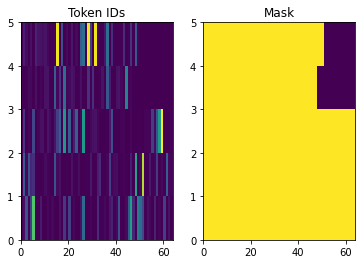

In [91]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

### Converting ID to Vector

In [92]:
user_df['reviewText'][0][0]

"My grandmother always had cashews in pretty glass containers in her living room. She loved cashews and lived to her late 80's eating them. I grew up on them. Now that we know that nuts are a healthy source of protein, they are a fairly non-guilty snack. Planters is a quality brand. This is our usual go-to brand when we want cashews. If you can eat about 1/8 cup at a time, they shouldn't destroy your diet."

In [93]:
input_vocab = enc_input_processor.get_vocabulary()
" ".join([input_vocab[id] for id in user_doc[0][0]])


'[START] my grandmother always had cashews in pretty glass containers in her living room . she loved cashews and lived to her late s eating them . i grew up on them . now that we know that nuts are a healthy source of protein , they are a fairly nonguilty snack . planters is a quality brand . this is our usual goto'

# **Context-aware Matrix Factorization for Rating Prediction**

In [94]:
#hyperparameters
num_users=len(user_to_row)
num_items=len(item_to_column)
mean_inv = np.float32( train_df['rating'].mean())



In [95]:
feature_num=128 # number of topics
units=int(feature_num/2 )# gru units

In [96]:
# del df
# del user_df
# del item_df
# del user_corpus[:]
# del item_corpus[:]
# del train_df
# del test_df

# gc.collect()
# gc.collect(0)
# gc.collect(1)
# gc.collect(2)

In [97]:
user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32)
item_textual_features = np.zeros(shape=(num_items, feature_num),dtype=np.float32)

In [98]:
user_recommender_features = np.zeros(shape=(num_users, feature_num),dtype=np.float64)
item_recommender_features = np.zeros(shape=(num_items, feature_num),dtype=np.float64)

## **PMF (Probabilistic Matrix Factorization)**

In [99]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.2, momentum=0.8,  batch_size=1024,num_item=9000,num_user=15000,mean_inv=3):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.rmse_train = []
        self.rmse_test = []
        self.mean_inv= mean_inv  
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def train(self):
            
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                  
                # Compute Objective Function             
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - batch_rating.numpy() + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - user_textual_features[batch_UserID,:] )
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] - item_textual_features[batch_ItemID,:] ) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
            self.evaluate()
            self.update_recommender_features()
    
    
    def evaluate(self):
            rawErr=np.zeros((self.batch_size),dtype=np.float64).tolist()
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                        
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr += pred_out - batch_rating.numpy() + self.mean_inv
        
            obj = np.linalg.norm(rawErr) ** 2 \
                    + 0.5 * self._lambda * (np.linalg.norm(self.U - user_textual_features) ** 2 + np.linalg.norm(self.V - item_textual_features) ** 2)

            self.rmse_train.append(np.sqrt(obj / train_data_num))

           # Compute test error
            rawErr=np.zeros((self.batch_size),dtype=np.float64).tolist()
            for batch_UserID,batch_ItemID, batch_rating  in test_ds_pmf:
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr += pred_out - batch_rating.numpy() + self.mean_inv

            self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(test_data_num))

            # Print info
            print('\nTraining RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))


    def update_recommender_features(self,):
        user_recommender_features = self.U
        item_recommender_features = self.V


# **Adversarial Seq2Seq Learning**

## **Metrics**

In [100]:
# log files for training and test
train_log_dir = 'logs/gradient_tape/'  + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/'  + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/'  
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [101]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

In [102]:
train_plx_gen_tch = PerplexityMetric(name='generator perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='generator perplexity')  # policy gradient mode
train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

test_plx_gen = PerplexityMetric(name='generator perplexity')  



## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [103]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding_dim=embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding( self.vocab_size, self.embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(  self.enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [104]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,embeddings_initializer=keras.initializers.Constant(full_embedding_matrix), trainable=False)
    self.gru=tf.keras.layers.GRU( self.dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(self.vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input = self.embedding(decoder_input)
     joint_input_context = tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state = self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist = self.sf(logits)

     return prob_dist,dec_state


In [105]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## **Discriminator**

In [106]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters
      self.dis_dropout_keep_prob = 0.75

      self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,weights=[full_embedding_matrix],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(self.dis_dropout_keep_prob,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid",use_bias= True)


    def get_reward(self, discriminator_inputs , context_vector,training=False ):
      
      embedded_input= self.embedding(discriminator_inputs)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      gmp_unigram = self.gmp_unigram(cv_unigram)
      gmp_bigram = self.gmp_bigram(cv_bigram)
      gmp_trigram =  self.gmp_trigram(cv_trigram)
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)
    
      gmp_overal = tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      
      if training:
        dropout = self.dropout(gmp_overal,training=training)
        ath= self.fc(dropout)
        gc.collect()
        return ath[:,0],self.fc.weights[0][:,0],self.fc.bias
      else:
        ath= self.fc(gmp_overal)
        gc.collect()
        return ath[:,0]



In [107]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.bce = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):

    loss = self.bce(y_true, y_pred)
    return loss

## **Seq2Seq Model**

In [108]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss_reward'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    loss *= reward
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [113]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self,num_topic,num_item ,num_user, units ,embedding_dim,vocab_size ,sequence_length, num_batches,num_batches_test, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches_test = num_batches_test
        self.num_batches = num_batches # train batch number
        self.batch_size = batch_size
        self.num_topic = num_topic
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.num_item = num_item
        self.num_user = num_user
        self.alpha = 10.0
        self.disc_l2_reg_lambda = 0.2
        self.user_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.item_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.decoder = Decoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, dec_units= 4 * self.units) #generator
        self.discriminator = Discriminator(sequence_length= self.sequence_length, vocab_size= self.vocab_size,embedding_dim= self.embedding_dim, filter_sizes= [1, 2, 3 ,4, 5] ,num_filters=128)
      
        self.loss_gn = GeneratorLoss(vocab_size=self.vocab_size)
        self.loss_ds = DiscriminatorLoss()
        self.loss_fn = MaskedLossReward(vocab_size=self.vocab_size) # generator loss with reward

        self.optimizer_gn = tf.optimizers.Adam(1e-4)
        self.optimizer_ds = tf.optimizers.Adam(1e-4)

    def generate_textual_features(self):
            
          for start_index in range(0, self.num_user, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_user)                           
            batch_userID = np.arange(start_index, end_index)

            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
            user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_userID))])
            
            user_textual_features[batch_userID]=user_context_vector.numpy()
            
          for start_index in range(0, self.num_item, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_item)                           
            batch_itemID = np.arange(start_index, end_index)

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
            item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_itemID))])
            
            item_textual_features[batch_itemID]=item_context_vector.numpy()
    
    def teacher_forcing_train(self,num_steps=1):
          total_gen_loss=0
          for t_step in range(num_steps):
 
            (batch_userID,batch_itemID ,batch_review_in,batch_review_out) = next(iter(train_ds_seq))
            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            with tf.GradientTape() as tape1 , tf.GradientTape() as tape2:
              tape1.watch(self.user_encoder.trainable_variables + self.item_encoder.trainable_variables)
              tape2.watch(self.decoder.trainable_variables)
              
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
                
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              context_vector = tf.concat( [user_context_vector,item_context_vector],1)
                           
              # regularization 
              user_regularization_loss= (np.linalg.norm( user_recommender_features[batch_userID.numpy()] - user_context_vector.numpy()) ** 2) /  user_context_vector.shape[0] 
              item_regularization_loss= (np.linalg.norm( item_recommender_features[batch_itemID.numpy()] - item_context_vector.numpy()) ** 2) /  item_context_vector.shape[0] 
              
              regularization_loss = tf.constant( self.alpha * (user_regularization_loss + item_regularization_loss) )
              dec_pred, _ = self.decoder( batch_review_in , context_vector)             
              gen_loss = self.loss_gn(batch_review_out , dec_pred)
           
            grad_enc = tape1.gradient([gen_loss,regularization_loss],self.user_encoder.trainable_variables + self.item_encoder.trainable_variables )
            grad_dec = tape2.gradient(gen_loss,self.decoder.trainable_variables )

            self.optimizer_gn.apply_gradients(zip(grad_enc+grad_dec, self.user_encoder.trainable_variables + self.item_encoder.trainable_variables+self.decoder.trainable_variables ))                 
            
            total_gen_loss += gen_loss
            # total_regularization_loss += regularization_loss
            if t_step % 10 == 0:
              print("batch number: ",t_step,"\tgen loss: ", gen_loss.numpy())
    
          train_plx_gen_tch.update_state(total_gen_loss / num_steps)

    def test(self,num_steps):
        total_loss=0
        for step in range(num_steps):
            (batch_userID,batch_itemID ,_,_) = next(iter(test_ds_seq))
            context_vector = tf.concat([user_textual_features[batch_userID.numpy()],item_textual_features[batch_itemID.numpy()]],1)                    
            predicted_samples,dec_prob = self.generate_sample(context_vector=context_vector)
            loss = self.loss_gn(predicted_samples ,tf.transpose( tf.stack(dec_prob), [1,0,2])  )
            total_loss += loss
            if step % 4 == 0:
              print("batch number: ",step, "\tgen loss: ",loss.numpy())

        test_plx_gen.update_state(total_loss / num_steps)
  

    
    def adversarial_train(self,num_steps=1):
        total_gen_loss=0
        for step in range(num_steps):
          # train generator for one step
          generated_samples,batch_userID,batch_itemID, gen_loss =  self._train_step_gn_policy() #adversarial samples
          total_gen_loss += gen_loss
          # train discriminator for one step
          disc_loss = self._train_step_disc(generated_samples,batch_userID,batch_itemID)
          if step % 5 == 0:
            print("batch number: ",step, "\t\tgen loss: ",gen_loss.numpy(),"\t\t\tdisc loss: ",disc_loss.numpy())   
        train_plx_gen_plc.update_state(total_gen_loss / num_steps)


    def _train_step_gn_policy(self):
            batch_userID = np.random.choice(range(0,self.num_user),self.batch_size).astype('int32')
            batch_itemID = np.random.choice(range(0,self.num_item),self.batch_size).astype('int32') 
            with tf.GradientTape() as tape:

              context_vector = tf.concat([user_textual_features[batch_userID],item_textual_features[batch_itemID]],1)                    
              generated_samples,dec_prob = self.generate_sample(context_vector=context_vector)            
              reward = self.discriminator.get_reward(generated_samples,context_vector)   # batchsize             
              g_loss = self.loss_fn(generated_samples , tf.transpose( tf.stack(dec_prob) , [1,0,2]) ,tf.tile( tf.expand_dims(reward,1),[1,self.sequence_length]).numpy() )
            
            variables =  self.decoder.trainable_variables 
            gradients = tape.gradient(g_loss, variables)                  
            self.optimizer_gn.apply_gradients(zip(gradients, variables))
            
            return generated_samples,batch_userID,batch_itemID,g_loss
       
    def _train_step_disc(self,negative_data,negative_user_indices,negative_item_indices):

          with tf.GradientTape() as tape:
            (positive_user_indices,positive_item_indices,_,positive_data) = next(iter(train_ds_seq)) # ground-truth data

            #data shape (batch_size * seq length)
            whole_user_indices = tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices = tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.zeros(batch_size, dtype=tf.int32) 
            negative_labels = tf.ones(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(user_textual_features , whole_user_indices) ,tf.gather( item_textual_features , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward,weights,bias = self.discriminator.get_reward( whole_data,query_embedding,training=True)
            l2_loss = tf.nn.l2_loss(2 * weights) + tf.nn.l2_loss(bias)
            disc_loss = self.loss_ds(labels,dis_reward) + (self.disc_l2_reg_lambda * l2_loss)
         
          variables = self.discriminator.trainable_variables 
          gradients = tape.gradient(disc_loss, variables)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))

          train_acc_dis.update_state(labels,dis_reward)
          return disc_loss


    def generate_sample(self, context_vector ):
   
        dec_out = [tf.convert_to_tensor(context_vector.shape[0] * [[2]])]
        dec_prob=[]
        dec_state=None    
        for _ in range(self.sequence_length):           
            d_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)          
            dec_prob.append(d_prob[:,-1])   
            dec_out.append(tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32))            
            del d_prob          
        gc.collect()
        
        return tf.squeeze(tf.stack(dec_out,1))[:,1:], dec_prob 


    
    def train(self,current_step):
        print("\n\nTeacher Forcing Train:")
        self.teacher_forcing_train(num_steps= 16)  # t step
        if current_step > -1:
          print("\n\nAdversarial Train:")          
          self.adversarial_train(num_steps= 4)     # g step
        print("\n\nGenerator Test:")          
        self.test(num_steps= self.num_batches_test)
       


# **Multi-Task Learning**

In [114]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model = PMF(num_feat=feature_num,num_item= num_items ,num_user= num_users, mean_inv=mean_inv)
        self.seq2seq_model = Seq2Seq(num_topic=feature_num,num_item= num_items ,num_user= num_users,units=units, embedding_dim= embedding_dim,vocab_size=full_embedding_matrix.shape[0],sequence_length=sequence_length, num_batches= num_batches,num_batches_test=num_batches_test,batch_size= batch_size)      
     
      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")
          #tf.profiler.experimental.start('logs')
          for epoch in range(n_epochs):
              print("\n\nepoch : ", int(ckpt.step))
              self.seq2seq_model.generate_textual_features()

              print("********************************************* PMF Model Training Turn *********************************************")
              self.pmf_model.train()
              print("\n\n******************************************* Seq2Seq Model Training Turn *******************************************")                                         
              self.seq2seq_model.train(int(ckpt.step))
             
              with train_summary_writer.as_default():
                  tf.summary.scalar('Training perplexity for generator in Teacher Forcing mode', train_plx_gen_tch.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training perplexity for generator in Policy Gradient mode', train_plx_gen_plc.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=int(ckpt.step))
              
              with test_summary_writer.as_default():
                  tf.summary.scalar('Test perplexity for generator', test_plx_gen.result(), step=int(ckpt.step))
  
              ckpt.step.assign_add(1)
              if int(ckpt.step) % 10 ==0:
                save_path = manager.save()
                print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            
          #tf.profiler.experimental.stop()


In [115]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=6000)


In [122]:
!tensorboard dev list


2022-12-17 17:53:20.406288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:53:20.425891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:53:20.426153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.goo

In [120]:
!tensorboard dev upload --logdir ./logs \
  --name "Simple experiment with ds" \
  --description "Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb" \
  --one_shot

2022-12-17 17:51:25.992833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:51:26.010557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 17:51:26.010758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<h

In [116]:
mt_model.train(n_epochs=3000)

Restored from ./tf_ckpts/ckpt-437


epoch :  4370


ValueError: Exception encountered when calling layer "encoder_4" (type Encoder).

In this `tf.Variable` creation, the initial value's shape ((28405, 300)) is not compatible with the explicitly supplied `shape` argument ((6191, 300)).

Call arguments received by layer "encoder_4" (type Encoder):
  • reviews=tf.Tensor(shape=(224, 64), dtype=int32)
  • state=None

# **Ploting Results**

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs
# deactive tracking protection of the page if you get 403 error


# test code

In [ ]:
#log_ps, mse_train, mse_test= pm.train(10)

In [ ]:

# dec_result,dec_state=decoder(dec_output_tokens,dec_output_tokens,context_vector= user_context_vector,state=dec_state)
# sampled_token = tf.random.categorical(dec_result[:,-1, :], num_samples=1)
# print( sampled_token.numpy())
# dec_output_tokens=np.append( dec_output_tokens , sampled_token.numpy()[0])
# print(dec_output_tokens)

# vocab = np.array(input_text_processor.get_vocabulary())
# first_word = vocab[dec_output_tokens]
# first_word